# BERTopic
### Extensive documentation on https://maartengr.github.io/BERTopic/index.html

### Load Modules

In [1]:
from bertopic import BERTopic
from sentence_transformers import SentenceTransformer

/Users/ssomani/mambaforge/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from sklearn.metrics.pairwise import cosine_similarity

In [3]:
%load_ext autoreload
%autoreload 2

In [14]:
import pandas as pd
import numpy as np

import re

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.cluster import KMeans, SpectralClustering, BisectingKMeans
from sklearn.preprocessing import MinMaxScaler as mms
from sklearn.decomposition import PCA
from umap import UMAP
from umap import plot as umap_plot

import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style('whitegrid')
sns.set_context('talk')

### Load Data

In [5]:
df = pd.read_excel('../data/raw/posts_comms_20220712.xlsx')

In [6]:
df.head(10)

,id,subreddit,query,type,author,content,date,upvotes
0,690frt,science,statin,post,[deleted],A new study helps debunk the widespread belief...,2017-05-03 06:47:46,0
1,4ifouo,todayilearned,lovastatin,post,[deleted],TIL When Merck Co. alleged Apotex infringed it...,2016-05-08 11:27:27,0
2,5h0c5g,keto,statin,post,sandy2622,I want to do keto...have health questions!. He...,2016-12-07 07:03:57,0
3,hkqpe9,keto,statin,post,SupraFast7159,High LDL - 9 months of Keto. My doctor is eage...,2020-07-03 13:50:26,0
4,ccrpay,keto,simvastatin,post,Jamaican_Baconx,High Cholesterol and LDL. I have a cholesterol...,2019-07-13 10:09:37,0
5,5t9qrj,keto,statin,post,MostlyTogether,Cholesterol numbers came in today. My husband ...,2017-02-10 12:34:21,0
6,2bezi4,keto,lipitor,post,wekiva,Lipitor and fat metabolism. I have been doing ...,2014-07-22 11:10:31,0
7,4t2m37,keto,statin,post,Missyne,Anybody knows a Doctor living in the Philippin...,2016-07-15 19:10:01,0
8,7ovjmf,conspiracy,lipitor,post,NaziModBeginsB,Dems rely on black &amp; women votes to win. H...,2018-01-07 18:56:00,0
9,2yyhaa,keto,statin,post,MetalMan77,"Cholesterol drop over 100pts after statin, rea...",2015-03-13 15:03:03,0


In [7]:
df.subreddit.value_counts()

keto                   2364
Cholesterol            2182
diabetes                879
science                 706
ketoscience             560
nutrition               503
ScientificNutrition     446
news                    443
todayilearned           381
conspiracy              375
Supplements             367
Health                  238
PlantBasedDiet          230
askscience              165
COVID19                 136
Paleo                   112
longevity                75
skeptic                  68
stopusingstatins          3
Name: subreddit, dtype: int64

In [8]:
# Fill empty cells and remove some weird html tags
df['content'].fillna("", inplace=True)
df.content = df.content.str.replace("http\S+", "")
df.content = df.content.str.replace("\\n", " ")
df.content = df.content.str.replace("&gt;", "") 

In [9]:
# Turn into list
texts = df['content']
texts_list = texts.to_list()

### Create Topic Models

In [253]:
# Calculate embeddings, so you don't have to do this every time you run the topic model
sentence_model = SentenceTransformer("all-MiniLM-L6-v2")
embeddings = sentence_model.encode(texts_list, show_progress_bar=True)

Batches: 100%|█████████████████████████████████████████████████████████████████████████████████| 320/320 [08:42<00:00,  1.63s/it]


In [165]:
# Let's see how our embeddings look like to begin with. 

umap_model = UMAP(n_neighbors=10, n_components=2, 
                  min_dist=0.0, metric='cosine', random_state=42)

umap_red_embs = umap_model.fit(embeddings)

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


<AxesSubplot:>

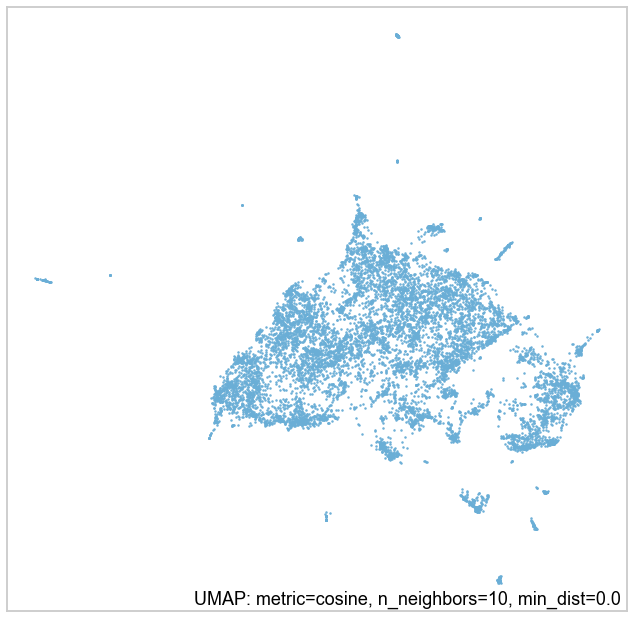

In [ ]:
umap_plot.points(umap_red_embs)

In [257]:
# If needed, this can be used to increase or decrease cluster size by changing the 'min_samples' parameter.
# Higher number means less clusters. Standard is 10.
# from hdbscan import HDBSCAN

#hdbscan_model = HDBSCAN(min_cluster_size=10, metric='euclidean', 
#                        cluster_selection_method='eom', prediction_data=True, min_samples=10)

In [171]:
# Train our topic model using our pre-trained sentence-transformers embeddings and UMAP to be able to provide a random seed
# nr_topics="auto" activates an automatic topic reduction method
umap_model = UMAP(n_neighbors=15, n_components=5, 
                  min_dist=0.0, metric='cosine', random_state=42)

# hdbscan_model = HDBSCAN(min_cluster_size=15, metric='euclidean', 
                       # cluster_selection_method='eom', prediction_data=True, min_samples=1) # Changed min_samples to 1, min_cluster_size to 30

topic_model = BERTopic(umap_model=umap_model, nr_topics="auto", calculate_probabilities=False)
topics, probs = topic_model.fit_transform(texts_list, embeddings)

In [172]:
topic_model.get_topic_info()

,Topic,Count,Name
0,-1,4921,-1_the_and_to_of
1,0,4555,0_the_and_to_of
2,1,127,1_coq10_q10_coenzyme_mitochondrial
3,2,78,2_rice_yeast_red_lovastatin
4,3,73,3_atorvastatin_side_effects_mg
5,4,62,4_grapefruit_juice_cyp3a4_the
6,5,59,5_simvastatin_sclerosis_ms_progressive
7,6,58,6_1000_daily_sublingually_mcg
8,7,49,7_fetal_tums_tylenol_preparation
9,8,46,8_niacin_internet_available_pmid


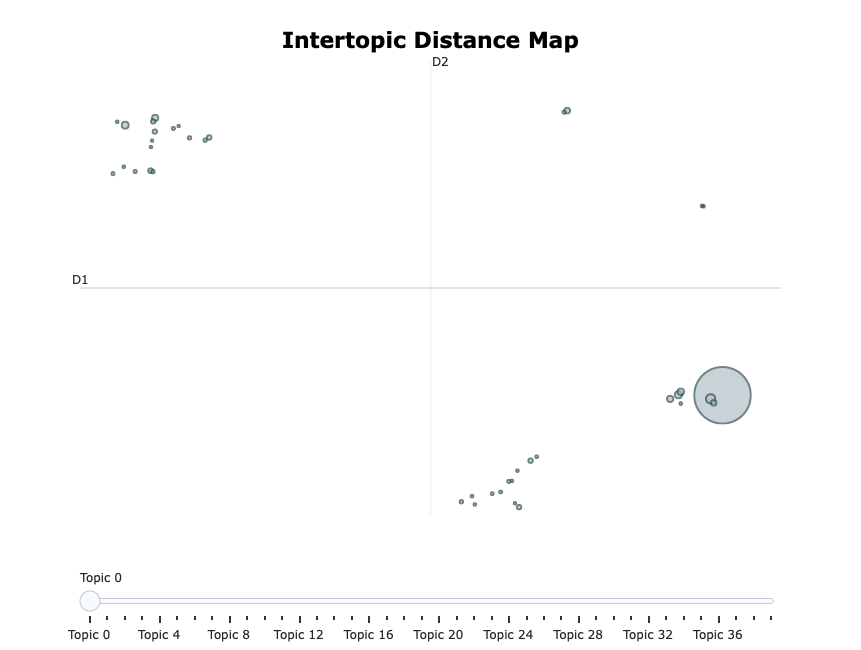

In [175]:
topic_model.visualize_topics()

In [105]:
# Or train model on new embeddings (run either the previous cell or this cell)
#vectorizer_model = CountVectorizer(stop_words="english")
#topic_model = BERTopic(vectorizer_model=vectorizer_model, verbose=True, calculate_probabilities=True)
#topics, probs = topic_model.fit_transform(texts_list)

Batches:   0%|          | 0/330 [00:00<?, ?it/s]

2022-07-14 15:40:36,437 - BERTopic - Transformed documents to Embeddings
2022-07-14 15:40:51,102 - BERTopic - Reduced dimensionality
2022-07-14 15:40:51,661 - BERTopic - Clustered reduced embeddings


In [ ]:
# Run this cell to load a pretrained topic model!
# topic_model = BERTopic.load("../models/topic_model_reduced_topics")
# probs = topic_model.hdbscan_model.probabilities_
# topics = topic_model._map_predictions(topic_model.hdbscan_model.labels_)

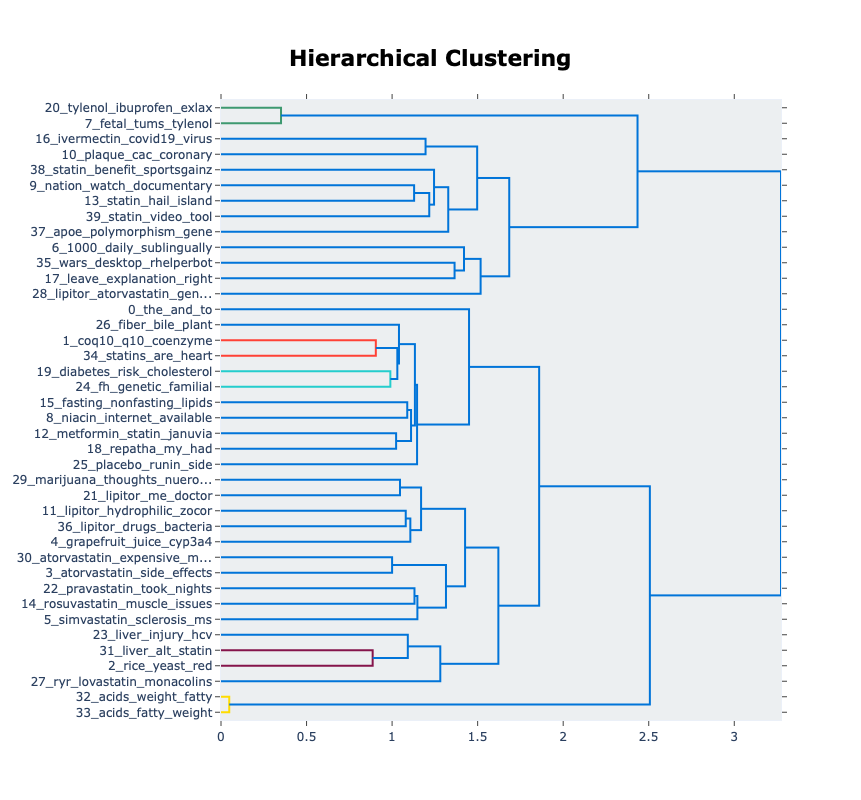

In [178]:
topic_model.visualize_hierarchy()

In [34]:
#topic_model.visualize_heatmap()

In [250]:
# manual assignment of topics to clusters
#df_topics['clusters'][df_topics['topics']==70] = 7

In [49]:
# Check if any topics are unassigned
#df_topics['topics'][df_topics['clusters']==0].unique()

In [145]:
#topic_model.save('topic_model_reduced_topics_2')

### Try with bigger n_gram range

In [79]:
# Reassign topic keywords by increasing ngram range
from sklearn.feature_extraction.text import CountVectorizer
vectorizer_model = CountVectorizer(ngram_range=(1, 4), stop_words="english")
topic_model.update_topics(texts_list, topics, vectorizer_model=vectorizer_model)

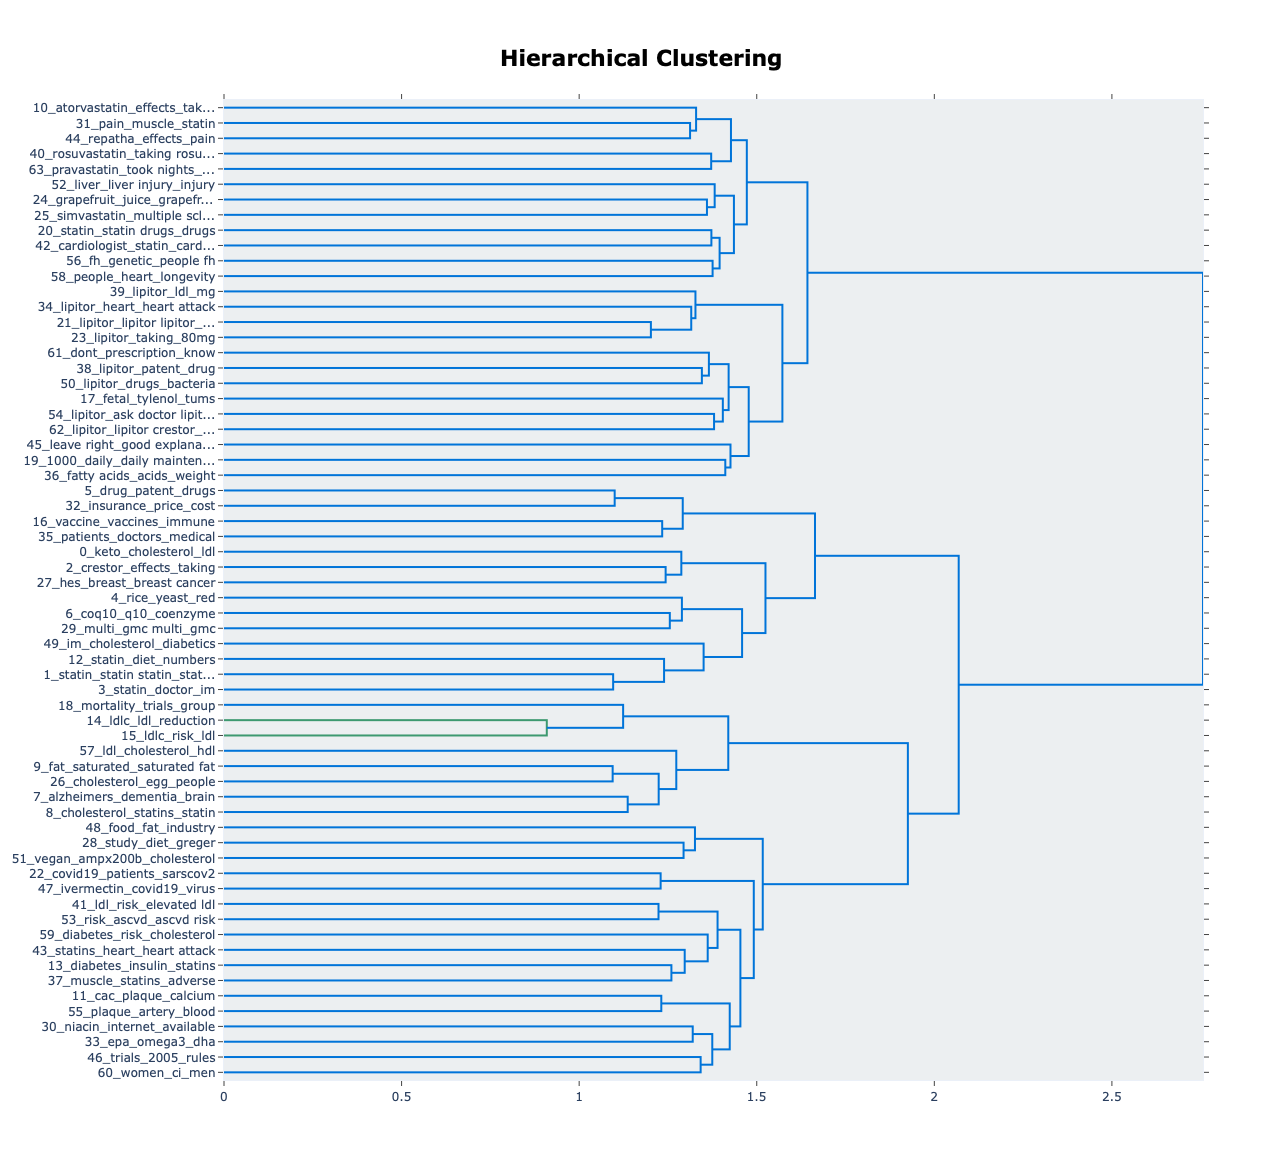

In [80]:
topic_model.visualize_hierarchy()

In [146]:
# Create document with topics and their keywords
topic_info_df = topic_model.get_topic_info()
topic_info_df.to_csv('topic_info_df_reduced_topics_2.csv')

### Assign outliers to topics

In [100]:
import numpy as np
probability_threshold = 0.01
new_topics = [np.argmax(prob) if max(prob) >= probability_threshold else -1 for prob in probs]

In [112]:
# Print number of outliers before and after assignment
print('Outliers before: ', topics.count(-1), '\nOutliers after: ', new_topics.count(-1))

Outliers before:  4382 
Outliers after:  1094


In [97]:
# test if there are texts to which multiple topics could be assigned
# current threshold: if the second topic has a probability that is less than 10% smaller
multiple_topics = []
for i in probs:
    prob = []
    if sorted(probs[0], reverse=True)[1] >= sorted(probs[0], reverse=True)[0]*0.9:
        prob.append(sorted(probs[0], reverse=True)[0])
        prob.append(sorted(probs[0], reverse=True)[1])
        if sorted(probs[0], reverse=True)[2] >= sorted(probs[0], reverse=True)[0]*0.9:
            prob.append(sorted(probs[0], reverse=True)[2])
            if sorted(probs[0], reverse=True)[3] >= sorted(probs[0], reverse=True)[0]*0.9:
                prob.append(sorted(probs[0], reverse=True)[3])
                if sorted(probs[0], reverse=True)[4] >= sorted(probs[0], reverse=True)[0]*0.9:
                    prob.append(sorted(probs[0], reverse=True)[4])
    multiple_topics.append(prob)

In [99]:
# prints the instances with multiple topics. If empty, none of the texts have multiple topics.
for i in multiple_topics:
    if i:
        print(i)

### Create df from topic model

In [282]:
def create_df_from_topic_model(topic_model, topics, texts_list):
    # Create df with texts and their assigned topics
    topic_docs = {topic: [] for topic in set(topics)}
    
    for topic, doc in zip(topics, texts_list):
        topic_docs[topic].append(doc)
        
    docs_list = []
    topics_list = []
    keywords_list = []

    for i in range(len(topic_docs.keys())):
        for j in topic_docs[i]:
            docs_list.append(j)
            topics_list.append(i)
            keywords_list.append(topic_model.get_topic(i))
            
    return pd.DataFrame({'texts':docs_list, 'topics':topics_list, 'keywords':keywords_list})

In [148]:
# Create df with texts and their assigned topics
topic_docs = {topic: [] for topic in set(topics)}
for topic, doc in zip(topics, texts_list):
    topic_docs[topic].append(doc)

In [149]:
docs_list = []
topics_list = []
keywords_list = []

for i in range(len(topic_docs.keys())):
    for j in topic_docs[i-1]:
        docs_list.append(j)
        topics_list.append(i-1)
        keywords_list.append(topic_model.get_topic(i-1))

In [150]:
df_topics = pd.DataFrame({'texts':docs_list, 'topics':topics_list, 'keywords':keywords_list})

In [252]:
df_topics.to_csv('df_topics_reduced_topics.csv')

## Clustering Trials

### Try with k-means instead of HDBScan (to reduce outliers)

In [228]:
cluster_model = KMeans(n_clusters=100, random_state=42)

umap_model = UMAP(n_neighbors=10, n_components=5, 
                  min_dist=0.0, metric='cosine', random_state=42)

k_means_topic_model = BERTopic(umap_model=umap_model, hdbscan_model=cluster_model)
k_means_topics, k_means_probs = k_means_topic_model.fit_transform(texts_list, embeddings)
vectorizer_model = CountVectorizer(ngram_range=(1, 4), stop_words="english")
k_means_topic_model.update_topics(texts_list, k_means_topics, vectorizer_model=vectorizer_model)

In [231]:
k_means_topic_model.get_topic_info()
k_means_topic_model.visualize_topics()
k_means_topic_model.visualize_hierarchy()

,Topic,Count,Name
0,0,227,0_a1c_metformin_blood_diabetes
1,1,218,1_ldlc_ldl_risk_mortality
2,2,209,2_ldl_diet_high_statin
3,3,206,3_drug_generic_drugs_patent
4,4,205,4_ldl_fh_statin_high
...,...,...,...
95,95,25,95_fatty acids_acids_weight_fatty
96,96,21,96_repatha_effects_pain_approved
97,97,19,97_im just going leave_good explanation really...
98,98,14,98_liver_liver injury_injury_liver injury vete...


### Try Clustering with BisectingKMeans

In [384]:
from sklearn.cluster import BisectingKMeans

cluster_model = BisectingKMeans(n_clusters=100, random_state=42)

umap_model = UMAP(n_neighbors=100, n_components=10, 
                  min_dist=0.0, metric='cosine', random_state=42)

bk_means_topic_model = BERTopic(umap_model=umap_model, hdbscan_model=cluster_model)
bk_means_topics, bk_means_probs = bk_means_topic_model.fit_transform(texts_list, embeddings)

vectorizer_model = CountVectorizer(ngram_range=(1, 4), stop_words="english")
bk_means_topic_model.update_topics(texts_list, bk_means_topics, vectorizer_model=vectorizer_model)

In [388]:
bk_means_topic_model.get_topic_info()
# bk_means_topic_model.visualize_topics()

,Topic,Count,Name
0,0,255,0_drug_generic_drugs_patent
1,1,231,1_ldl_keto_hdl_high
2,2,225,2_drug_drugs_insurance_pay
3,3,199,3_ldlc_ldl_risk_studies
4,4,199,4_statin_statin facts_statin nation_nation
...,...,...,...
95,95,31,95_crestor_repatha_cholesterol_went
96,96,30,96_ivermectin_covid19_virus_showing
97,97,24,97_cholesterol_risk_diabetes_patient
98,98,18,98_ryr_lovastatin_monacolin_product


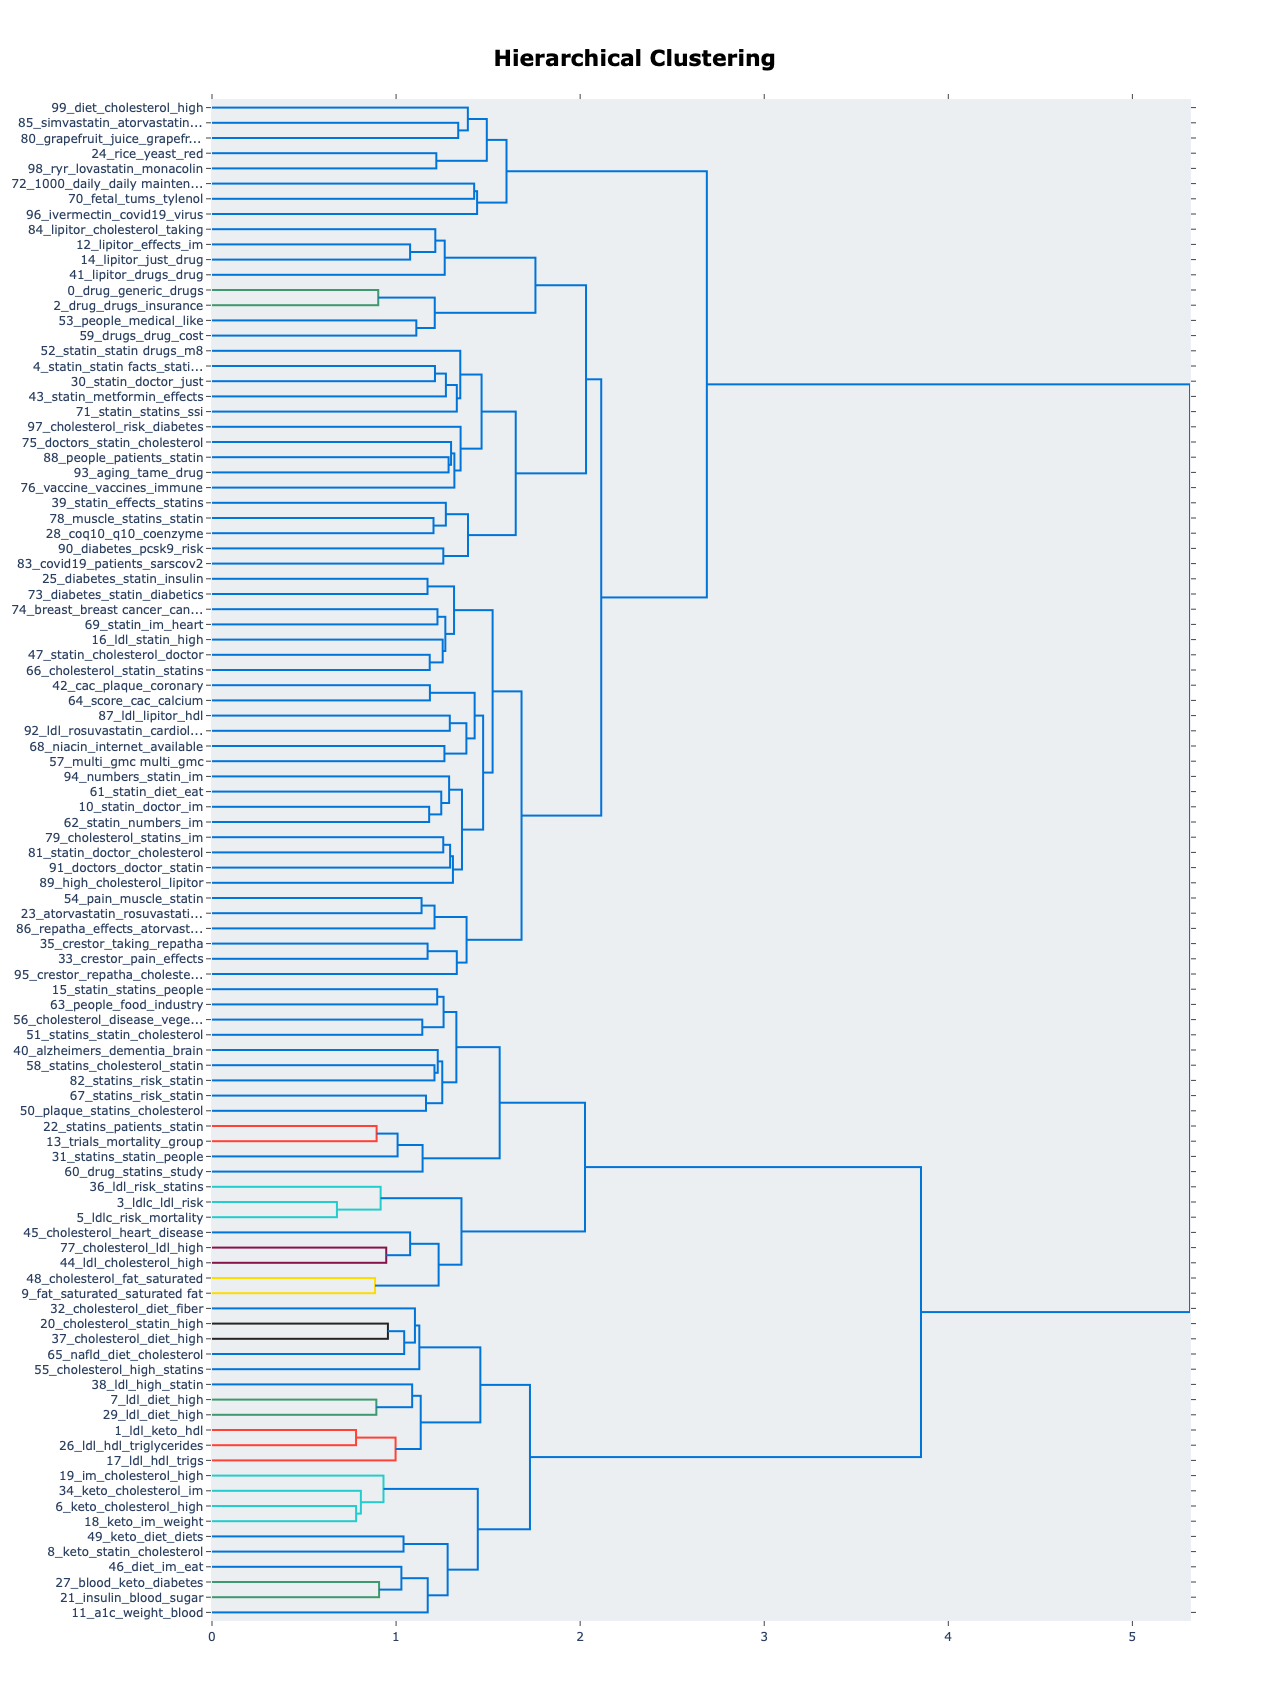

In [389]:
bk_means_topic_model.visualize_hierarchy()

In [390]:
df_bkm = create_df_from_topic_model(bk_means_topic_model, bk_means_topics, texts_list)
df_bkm.loc[df_bkm['texts'].apply(lambda x : 'muscle' in str(x)), 'topics'].value_counts()

54    45
78    30
28    29
23    26
19    14
      ..
38     1
30     1
10     1
98     1
73     1
Name: topics, Length: 90, dtype: int64

### Try Visualizing Our Raw Data

In [1000]:
import datashader as ds
import colorcet

In [253]:
# Calculate embeddings, so you don't have to do this every time you run the topic model
sentence_model = SentenceTransformer("all-MiniLM-L6-v2")
embeddings = sentence_model.encode(texts_list, show_progress_bar=True)

Batches: 100%|█████████████████████████████████████████████████████████████████████████████████| 320/320 [08:42<00:00,  1.63s/it]


In [1014]:
# Let's see how our embeddings look like to begin with. 

umap_model = UMAP(n_neighbors=10, n_components=2, 
                  min_dist=0.0, metric='cosine', random_state=42)
umap_red_embs = umap_model.fit(embeddings)

In [ ]:
umap_red_embs_df = pd.DataFrame(umap_red_embs.transform(embeddings), columns=['x', 'y'])
sns.scatterplot(np.array(umap_red_embs_df))

### Try Clustering with Spectral Clustering

In [11]:
# Calculate embeddings, so you don't have to do this every time you run the topic model
sentence_model = SentenceTransformer("all-MiniLM-L6-v2")
embeddings = sentence_model.encode(texts_list, show_progress_bar=True)

Batches: 100%|████████████████████████████████| 320/320 [08:37<00:00,  1.62s/it]


In [12]:
cluster_model = SpectralClustering(n_clusters=100, random_state=42)

umap_model = UMAP(n_neighbors=100, n_components=10, 
                  min_dist=0.0, metric='cosine', random_state=42)

spec_topic_model = BERTopic(umap_model=umap_model, hdbscan_model=cluster_model)

In [13]:
spec_topics, spec_probs = spec_topic_model.fit_transform(texts_list, embeddings)

#### Hierarchy and Model Topic Changes

In [ ]:
# vectorizer_model = CountVectorizer(ngram_range=(1, 4), stop_words="english")
# spec_topic_model.update_topics(texts_list, spec_topics, vectorizer_model=vectorizer_model)

In [15]:
# df_spec = create_df_from_topic_model(spec_topic_model, spec_topics, texts_list)

NameError: name 'create_df_from_topic_model' is not defined

In [ ]:
# hierarchy = spec_topic_model.hierarchical_topics(texts_list, spec_topics)

In [38]:
df['topic'] = spec_topics
kw = spec_topic_model.get_topic_info()['Name']
df['group'] = [c_tf_idf_embed_clust[i] for i in df['topic']]
df['keywords'] = [kw.loc[i] for i in df['topic']]
df.to_excel('/Users/ssomani/Desktop/df_grouped.xlsx')

In [551]:
hierarchy['Child_Left_ID'] = hierarchy['Child_Left_ID'].astype('int')
hierarchy['Parent_ID'] = hierarchy['Parent_ID'].astype('int')
hierarchy['Child_Right_ID'] = hierarchy['Child_Right_ID'].astype('int')

In [535]:
hierarchy.to_excel('/Users/ssomani/Desktop/testing.xlsx')

In [557]:
def convert_hierarchy_to_json_tree(level, hierarchy, topic_info):
    
    if level > topic_info.index.max():
        
        # Record children
        left_child = hierarchy.loc[level - 100, 'Child_Left_ID']
        right_child = hierarchy.loc[level - 100, 'Child_Right_ID']
        
        return {
            'name' : hierarchy.loc[level - 100, 'Parent_Name'],
            'children' : [
                convert_hierarchy_to_json_tree(left_child, hierarchy, topic_info),
                convert_hierarchy_to_json_tree(right_child, hierarchy, topic_info)
            ]
        }
        
    else:
        return {
            'name' : topic_info.loc[level, 'Name'],
            'size' : str(topic_info.loc[level, 'Count'])
        }

In [558]:
a = convert_hierarchy_to_json_tree(198, hierarchy, topic_info)

In [559]:
with open('/Users/ssomani/Desktop/temp.json', 'w') as f:
    json.dump(a, f)

In [743]:
from copy import deepcopy

In [744]:
spec_topic_model_save = deepcopy(spec_topic_model)

In [ ]:
spec_topic_model = deepcopy(spec_topic_model_save)

In [807]:
spec_topic_model.merge_topics(texts_list, spec_topics, merge_array)

#### Back to Regular

In [16]:
def find_most_common_subreddit_per_cluster(df, topics):
    subreddits = df['subreddit'].unique()
    subreddit_per_topic = pd.DataFrame(index=np.arange(np.max(topics) + 1), columns=subreddits).fillna(0)
    
    for i, topic_i in enumerate(topics):
        subreddit_i = df.loc[i, 'subreddit']
        subreddit_per_topic.loc[topic_i, subreddit_i] += 1
    
    # Now, find which subreddit corresponds to each topic
    return [subreddits[subreddit_per_topic.iloc[i].argmax()] for i in np.arange(np.max(topics) + 1)]

def find_number_of_users_subreddit_per_cluster(df, topics, topic_model):
    topic_np = np.array(topics)
    base = [df.iloc[np.where(topic_np == i)[0]]['author'].nunique() for i in range(np.max(topics) + 1)]
    return np.array(base) / topic_model.get_topic_info()['Count']

subreddit_by_cluster = find_most_common_subreddit_per_cluster(df, spec_topics)
unique_users_by_cluster = find_number_of_users_subreddit_per_cluster(df, spec_topics, spec_topic_model)

In [17]:
def create_new_topic_names(topic_model, groups):
    topic_names = topic_model.get_topic_info()['Name'].split('_')[1:]
    raise NotImplementedError

In [18]:
c_tf_idf_mms = mms().fit_transform(spec_topic_model.c_tf_idf.toarray())
c_tf_idf_embed_vis = UMAP(n_neighbors=4, n_components=2, metric='hellinger', random_state=42).fit_transform(c_tf_idf_mms)
c_tf_idf_embed = UMAP(n_neighbors=4, n_components=3, metric='hellinger', random_state=42).fit_transform(c_tf_idf_mms)

In [36]:
from sklearn.metrics import silhouette_score

def find_silhouette_scores(c_tf_idf_embed, llim=3, ulim=25):
    
    ss = []
    cluster_arr = np.arange(llim, ulim)
    
    for n_clusters in cluster_arr:
        clusters = SpectralClustering(n_clusters=n_clusters, random_state=42).fit_predict(c_tf_idf_embed)
        ss.append(silhouette_score(c_tf_idf_embed, clusters))
        
    with sns.plotting_context('notebook'):
        sns.set_style('ticks')
        plt.figure(figsize=(5, 3))
        ax = sns.lineplot(x=cluster_arr, y=ss, palette='autumn')
        ax.set_title('Silhouette Score per Cluster', {'fontsize' : 16})
        plt.show(ax)

    ideal_n_clusters = cluster_arr[np.argmax(ss)]

    print("top silhouette score: {0:0.3f} for at n_clusters {1}".format(np.max(ss), ideal_n_clusters))
    
    return ideal_n_clusters

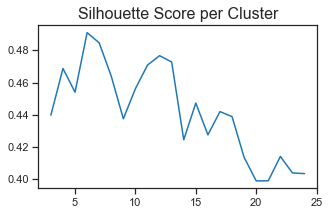

top silhouette score: 0.491 for at n_clusters 6


In [37]:
ideal_n_clusters = find_silhouette_scores(c_tf_idf_embed)

In [38]:
c_tf_idf_embed_clust = SpectralClustering(n_clusters=ideal_n_clusters, random_state=42).fit_predict(c_tf_idf_embed)

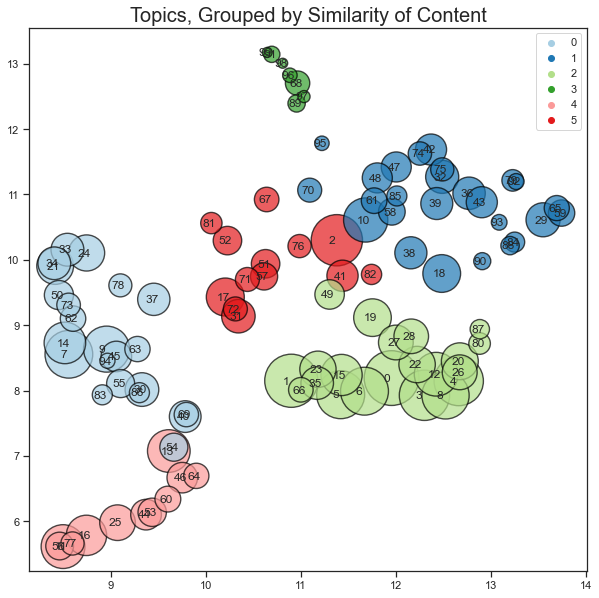

In [40]:
with sns.plotting_context('notebook'):
    sns.set_style('ticks')
    plt.figure(figsize=(10, 10))
    ax = sns.scatterplot(*c_tf_idf_embed_vis.T, size=spec_topic_model.get_topic_info()['Count'], \
                    hue=c_tf_idf_embed_clust, sizes=(100, 3000), \
                    alpha=0.7, palette='Paired', legend=True, edgecolor='k')
    h,l = ax.get_legend_handles_labels()
    for i, coords in enumerate(c_tf_idf_embed_vis):
        ax.annotate(i, coords - [0.09, 0.05])
    plt.legend(h[0:ideal_n_clusters],l[0:ideal_n_clusters]) #,bbox_to_anchor=(1.05, 1) , loc=2, borderaxespad=0., fontsize=13)
    ax.set_title('Topics, Grouped by Similarity of Content', {'fontsize' : 20})
    plt.show(ax)

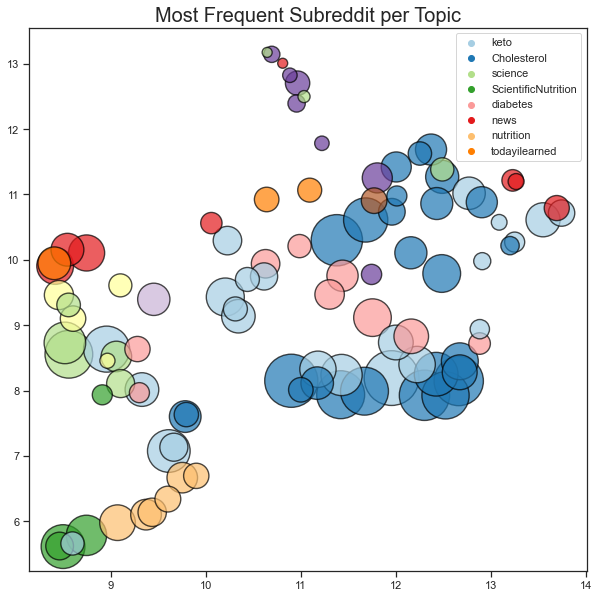

In [41]:
with sns.plotting_context('notebook'):
    sns.set_style('ticks')
    plt.figure(figsize=(10, 10))
    ax = sns.scatterplot(*c_tf_idf_embed_vis.T, size=spec_topic_model.get_topic_info()['Count'], \
                    hue=subreddit_by_cluster, sizes=(100, 3000), \
                    alpha=0.7, palette='Paired', legend=True, edgecolor='k')
    ax.set_title('Most Frequent Subreddit per Topic', {'fontsize' : 20})
    h,l = ax.get_legend_handles_labels()
    plt.legend(h[0:8],l[0:8]) #,bbox_to_anchor=(1.05, 1) , loc=2, borderaxespad=0., fontsize=13)
    plt.show(ax)

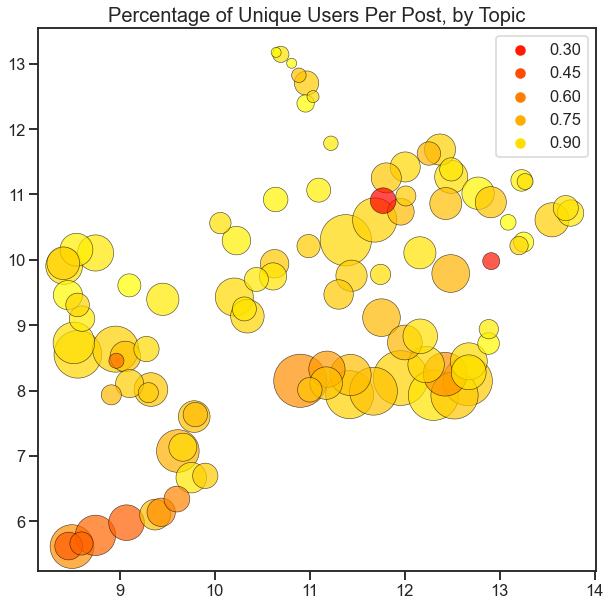

In [42]:
with sns.plotting_context('talk'):
    sns.set_style('ticks')
    plt.figure(figsize=(10, 10))
    ax = sns.scatterplot(*c_tf_idf_embed_vis.T, size=spec_topic_model.get_topic_info()['Count'], \
                    hue=unique_users_by_cluster, sizes=(100, 3000), \
                    alpha=0.7, palette='autumn', legend=True, edgecolor='k', linewidth=0.6)
    ax.set_title('Percentage of Unique Users Per Post, by Topic', {'fontsize' : 20})
    h,l = ax.get_legend_handles_labels()
    plt.legend(h[0:5],l[0:5]) #,bbox_to_anchor=(1.05, 1) , loc=2, borderaxespad=0., fontsize=13)
    plt.show(ax)

In [887]:
texts[0]

'A new study helps debunk the widespread belief that statins cause muscle-related pain and weakness in large numbers of patients. The “nocebo effect” may be the cause of the epidemic of muscle pain among statin users, say the study investigators and outside commentators.. [deleted]'

In [884]:
merge_array = [np.where(c_tf_idf_embed_clust == i)[0].tolist() for i in range(c_tf_idf_embed_clust.max() + 1)]
merge_array

[[0, 1, 4, 6, 8, 12, 15, 17, 20],
 [32, 36, 39, 42, 43, 47, 58, 67, 70, 74, 75, 79, 84, 88, 90, 92, 93],
 [9, 30, 40, 55, 63, 66, 69, 71, 77, 83, 85, 86],
 [3, 7, 11, 13, 16, 25, 31, 44, 45, 46, 53, 54, 56, 60, 64],
 [41, 48, 61, 68, 82, 89, 91, 95, 96, 97, 98, 99],
 [14, 21, 24, 33, 34, 50, 62, 72, 73, 94],
 [2,
  5,
  10,
  18,
  23,
  26,
  29,
  35,
  37,
  38,
  51,
  52,
  57,
  59,
  65,
  76,
  78,
  80,
  81,
  87],
 [19, 22, 27, 28, 49]]

In [591]:
overlap = pd.DataFrame(index=np.arange(0, 100), columns=np.arange(0, 100)).fillna(0)

for topic_i, keywords_i in spec_topic_model.get_topics().items():
    for topic_j, keywords_j in spec_topic_model.get_topics().items():
        kw_i, kw_j = np.array(keywords_i)[:, 0], np.array(keywords_j)[:, 0]
        overlap.loc[topic_i, topic_j] = np.intersect1d(kw_i, kw_j).shape[0] / kw_i.shape[0]

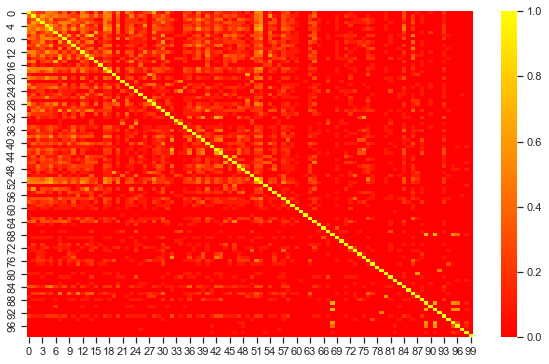

In [813]:
with sns.plotting_context('notebook'):
    plt.figure(figsize=(10, 6))
    ax = sns.heatmap(overlap, cmap='autumn')

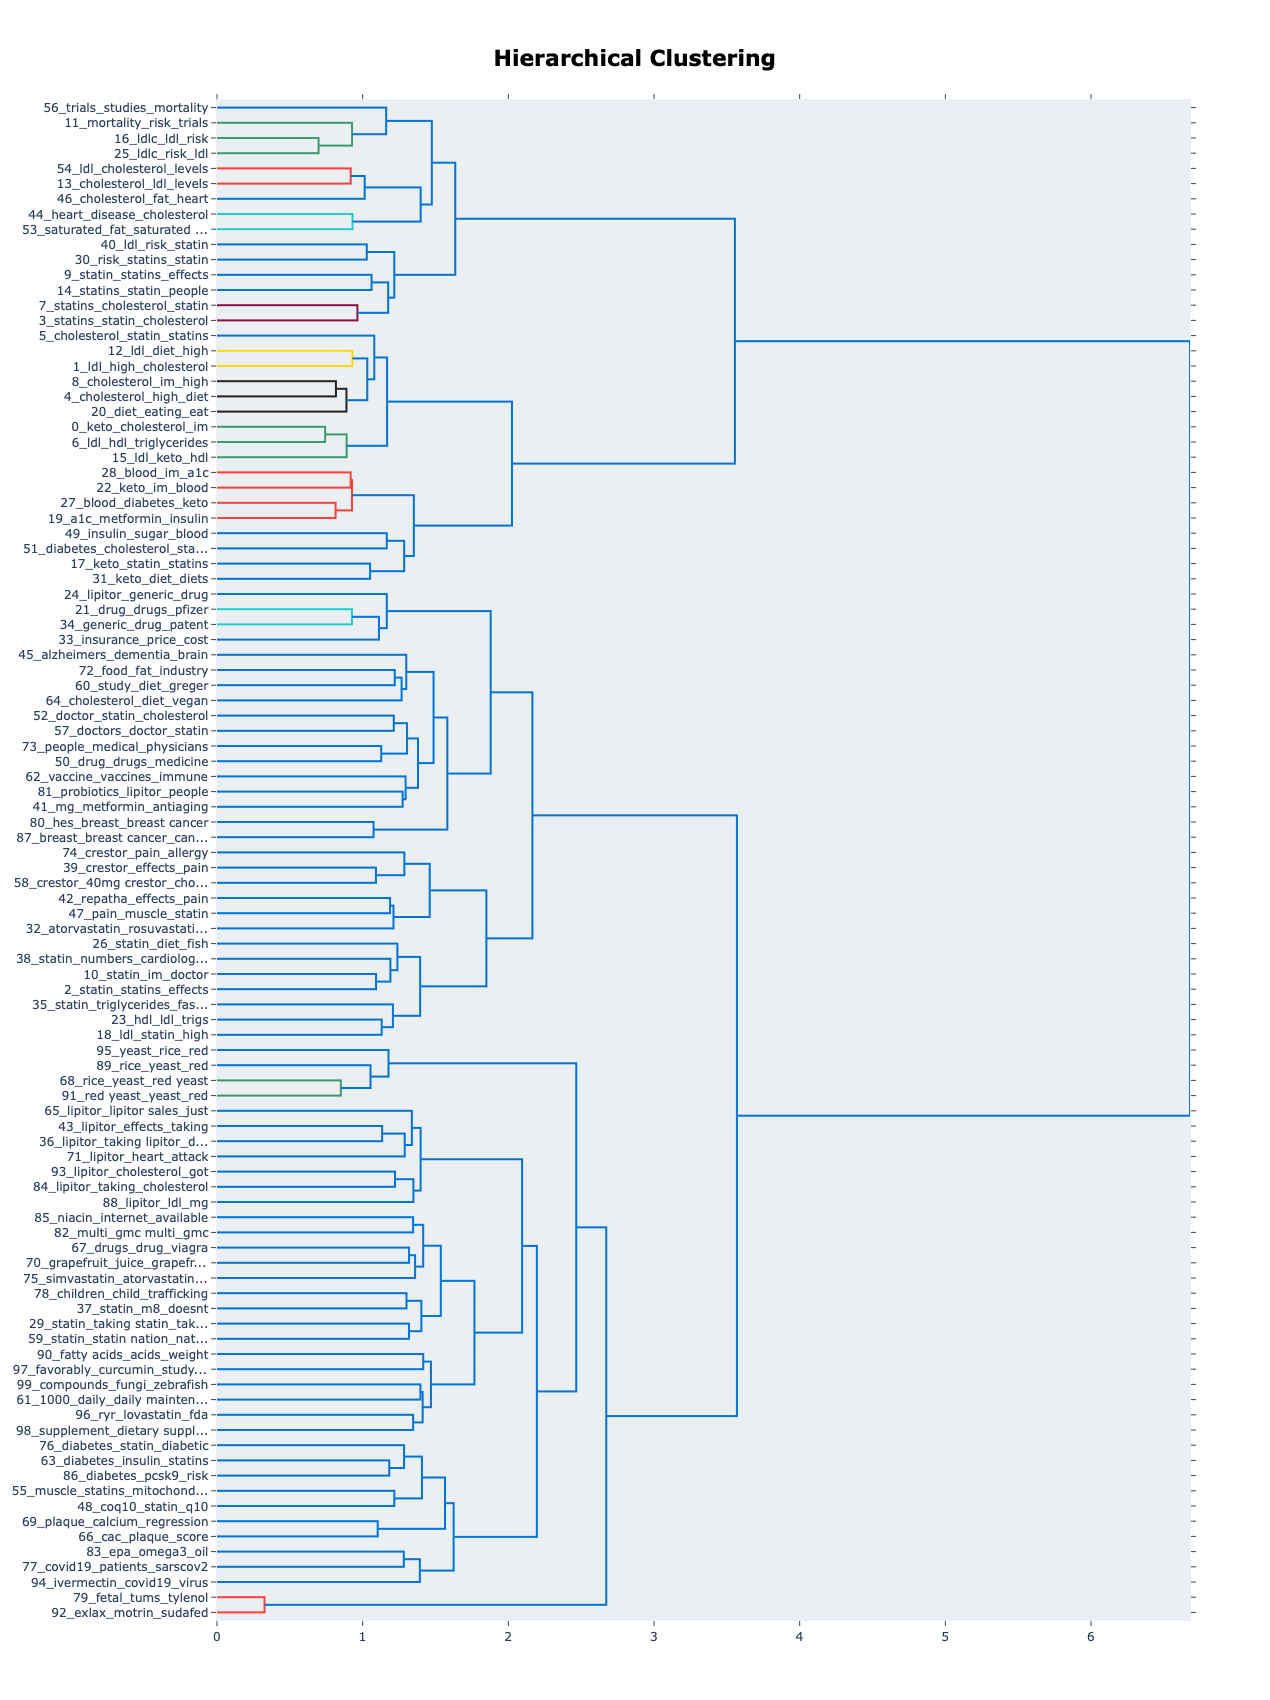

In [561]:
spec_topic_model.visualize_hierarchy()

# Other Random

## Try with seeded topics

In [26]:
seed_topic_list = [['myalgia', 'muscle', 'pain', 'weakness', 'creatine kinase', 'CK',  'nausea', 'vomiting', 'indigestion', 'liver enzymes', 'LFT', 'AST', 'ALT', 'memory loss', 'brain fog', 'irritable', 'dementia', 'poison', 'kill', 'side effect', 'infection'],
                   ['reduce', 'lower', 'improve', 'cholesterol', 'LDL', 'HDL', 'stroke', 'heart attack', 'artery', 'clean', 'triglyceride'],
                    ['diet', 'exercise', 'carbs', 'carbohydrates', 'fat', 'red meat', 'keto', 'fasting'],
                  ['expensive', 'price', 'profit', 'insurance', 'bill', 'money', 'poor'],
                  ['cardiologist', 'primary care', 'dentist'],
                  ['dose', 'interaction', 'other medications', 'antibiotic'],
                  ['diabetes', 'obesity', 'stroke']]

seeded_topic_model = BERTopic(seed_topic_list=seed_topic_list)
seeded_topics, seeded_probs = seeded_topic_model.fit_transform(texts)

2022-06-27 17:29:47,174 - BERTopic - Transformed documents to Embeddings
2022-06-27 17:29:57,294 - BERTopic - Reduced dimensionality
2022-06-27 17:29:57,365 - BERTopic - Clustered reduced embeddings


In [28]:
seeded_topic_model.get_topic_info()

,Topic,Count,Name
0,-1,827,-1_to_and_the_my
1,0,157,0_statins_statin_the_prevention
2,1,89,1_statins_cholesterol_of_the
3,2,81,2_ldlc_of_the_risk
4,3,63,3_my_cholesterol_and_ldl
5,4,56,4_my_ldl_paleo_and
6,5,53,5_10mg_my_dose_rosuvastatin
7,6,49,6_keto_my_ldl_cholesterol
8,7,41,7_drugs_drug_the_industry
10,8,39,8_yeast_rice_red_cholesterol


In [29]:
seeded_topic_docs = {topic: [] for topic in set(topics)}
for topic, doc in zip(topics, texts_list):
    seeded_topic_docs[topic].append(doc)

In [30]:
seeded_docs_list = []
seeded_topics_list = []
seeded_keywords_list = []

for i in range(len(seeded_topic_docs.keys())):
    for j in seeded_topic_docs[i-1]:
        seeded_docs_list.append(j)
        seeded_topics_list.append(i-1)
        seeded_keywords_list.append(topic_model.get_topic(i-1))

In [31]:
seeded_df_topics = pd.DataFrame({'texts':seeded_docs_list, 'topics':seeded_topics_list, 'keywords':seeded_keywords_list})

In [32]:
seeded_df_topics.to_csv('seeded_df_topics.csv')

## Try with r/cholesterol instead of other dataset

In [33]:
df_chol_posts = pd.read_excel('/Users/mariekevb/Desktop/Stanford/statins/data/posts_rcholesterol_20220623.xlsx')
df_chol_comments = pd.read_excel('/Users/mariekevb/Desktop/Stanford/statins/data/comments_rcholesterol_20220623.xlsx')

In [34]:
df_chol_comments.columns

Index(['Unnamed: 0', 'query', 'subreddit', 'id', 'author', 'title', 'body',
       'date', 'link_id', 'parent_id', 'upvotes'],
      dtype='object')

In [35]:
df_chol_posts['body'] = df_chol_posts['body'].fillna('')
df_chol_posts['combi'] = df_chol_posts['title'] + '. ' + df_chol_posts['body']
df_chol_posts.combi = df_chol_posts.apply(lambda row: re.sub(r"http\S+", "", row.combi).lower(), 1)
df_chol_posts.combi = df_chol_posts.apply(lambda row: " ".join(filter(lambda x:x[0]!="@", row.combi.split())), 1)

In [36]:
chol_texts = df_chol_posts['combi']
chol_texts = chol_texts.append(df_chol_comments['body'])
chol_texts_list = chol_texts.to_list()

In [37]:
chol_topic_model = BERTopic(vectorizer_model=vectorizer_model, verbose=True)
chol_topics, chol_probs = chol_topic_model.fit_transform(chol_texts_list)

Batches:   0%|          | 0/83 [00:00<?, ?it/s]

2022-06-27 17:30:53,236 - BERTopic - Transformed documents to Embeddings
2022-06-27 17:31:05,722 - BERTopic - Reduced dimensionality
2022-06-27 17:31:05,824 - BERTopic - Clustered reduced embeddings


In [39]:
chol_topic_model.get_topic_info()

,Topic,Count,Name
0,-1,1026,-1_cholesterol_statin_ldl_high
1,0,166,0_ldl_statin_diet_high
2,1,149,1_crestor_taking_effects_ive
3,2,70,2_cholesterol_statin_high_high cholesterol
4,3,64,3_im_cholesterol_years_diet
5,4,61,4_cholesterol_diet_like_high
6,5,59,5_statin_life_taking statin_statin statin
7,6,55,6_statin_diet_months_exercise
8,7,52,7_lipitor_80mg_effects_different
9,8,50,8_cholesterol_pain_heart_statins


## Use below to search through topics

In [40]:
# get top words for specific topic
topic_model.get_topic(topic =0)

[('statins', 0.0443514906529007),
 ('statin', 0.03552898941863199),
 ('cardiovascular', 0.017146035487514713),
 ('primary prevention', 0.015819716478343872),
 ('prevention', 0.014476579661165027),
 ('statin discontinuation', 0.014028100402538966),
 ('study', 0.014015372996630563),
 ('event', 0.013959535781059256),
 ('discontinuation', 0.013747472771007617),
 ('primary', 0.01270304876821225)]

In [41]:
# get representative documents for specific topic
topic_model.get_representative_docs(topic=0)

["statins' flawed studies and false advertising.",
 'esselstyn: the problems with statin drugs .',
 'statin wars: have we been misled about the evidence? a narrative review [summary].']